Mount Google Drive and extract the training and test data from the respective pickle files.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
data_dir = 'gdrive/My Drive/Colab Notebooks/AuthorshipAttribution/data' # @param {type:"string"}


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pickle

train_data, test_data = None, None
with open(data_dir + "/train_data.pickle", "rb") as f:
    train_data = pickle.load(f)
with open(data_dir + "/test_data.pickle", "rb") as f:
    test_data = pickle.load(f)

In [0]:
x_train = train_data['train_texts']
y_train = train_data['train_labels']

x_test = test_data['test_texts']
y_test = test_data['test_labels']

Convert the training and testing reviews into a matrix of TF/IDF features using sklearn.

In [0]:
%%time

from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
word_vec = TfidfVectorizer(min_df=5, ngram_range=(1,2), lowercase=False)
char_vec = TfidfVectorizer(min_df=5, ngram_range=(2,3), lowercase=False)

fu = FeatureUnion([
    ('word', word_vec),
    ('char', char_vec)
])

X_train = fu.fit_transform(x_train)

CPU times: user 6.11 s, sys: 350 ms, total: 6.46 s
Wall time: 6.55 s


In [0]:
X_train.shape

(50, 28206)

In [0]:
X_test = fu.transform(x_test)

Instantiate a linear support vector classification object from sklearn.

In [0]:
from sklearn.svm import LinearSVC

svm = LinearSVC()

Fit the training data to the LinearSVC model.

In [0]:
%%time

svm.fit(X_train, y_train)

CPU times: user 1.19 s, sys: 3.83 ms, total: 1.2 s
Wall time: 1.21 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Using the trained model from above, predict the authors for the test reviews and calculate the accuracy.

In [0]:
preds = svm.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds)

0.4624

The accuracy we get from this is quite low. This is because our test reviews are too short.

In [0]:
def get_chunks(l, n):
    n = max(1, n)
    return [l[i:i+n] for i in range(0, len(l), n)]

In [0]:
print(len(x_test))
print(len(y_test))

2500
2500


In [0]:
from statistics import mean
word_counts = [text.count(" ") for text in x_test]
mean(word_counts)

182.5416

We join multiple test reviews, in this case 5, to get longer test reviews.

In [0]:
# 182 words is quite short
# Try to join 5 tests texts together
longer_test_texts = get_chunks(x_test, 5)
longer_test_labels = get_chunks(y_test, 5)

In [0]:
all([len(set(x)) == 1 for x in longer_test_labels])  # Make sure that all combined labels are the same

True

In [0]:
longer_test_texts = ['\n'.join(chunk) for chunk in longer_test_texts]

In [0]:
longer_test_labels = [chunk[0] for chunk in longer_test_labels]

In [0]:
len(longer_test_texts)

500

In [0]:
X_test_longer = fu.transform(longer_test_texts)

We use the same trained SVM model from before and perform testing on the new longer test reviews, and get a much better accuracy score.

In [0]:
preds = svm.predict(X_test_longer)

In [0]:
accuracy_score(longer_test_labels, preds)

0.908

We then go on to compute the confusion matrix and f1 score for our model.

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
from sklearn.metrics import f1_score
f1_score(longer_test_labels, preds, average='macro')

0.9003983905994943

In [0]:
# !pip install matplotlib
import matplotlib.pyplot as plt


In [0]:
cm = confusion_matrix(longer_test_labels, preds)

In [0]:
cm

array([[ 7,  0,  1, ...,  0,  0,  0],
       [ 0, 10,  0, ...,  0,  0,  0],
       [ 0,  0, 10, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  9,  0,  0],
       [ 0,  0,  0, ...,  0, 10,  0],
       [ 0,  0,  0, ...,  0,  0, 10]])

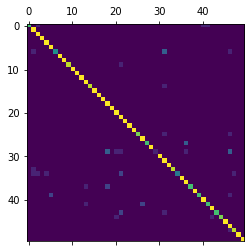

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)

In [0]:
from sklearn.metrics import classification_report

In [0]:
print(classification_report(longer_test_labels, preds))

              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.77      1.00      0.87        10
           2       0.83      1.00      0.91        10
           3       1.00      1.00      1.00        10
           4       0.91      1.00      0.95        10
           5       0.83      1.00      0.91        10
           6       1.00      0.50      0.67        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       1.00      0.90      0.95        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       0.83      1.00      0.91        10
          14       1.00      0.90      0.95        10
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00        10
          17       1.00    